# 결정 나무 & 랜덤 포레스트 다중 분류
- 펭귄 데이터 셋

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 데이터 준비

In [135]:
# window 베이스에서는 wget이 없음
# 해당 라이브러리 다운로드 or 프로그램 상으로 파일 받기
#!wget https://raw.githubusercontent.com/devdio/flyai_datasets/main/penguins.csv

In [136]:
penguins = pd.read_csv('penguins.csv')
penguins.shape

(344, 7)

In [137]:
# 3종류 펭귄 데이터가 존재, 무게, 길이 등으로 분류함
# Species - Adelie, Chinstrap, Gentoo
df = penguins.copy()
df.head()

,Species,Island,Culmen Length(mm),Culmen Depth(mm),Flipper Length(mm),Body Mass(g),Sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [138]:
# 컬럼 처리
df.columns = [col.lower().replace(' ', '_').replace('(', '_').replace(')', '') for col in df.columns]
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [140]:
# object -> 숫자로 변경
# 결측치
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [141]:
# 이상치 확인 - 없는듯
df.describe().T

,count,mean,std,min,25%,50%,75%,max
culmen_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6
culmen_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0


### 범주형 변수

In [142]:
# 범주형 데이터 뽑기
cols_cat = df.select_dtypes(include='object')
cols_cat

,species,island,sex
0,Adelie,Torgersen,MALE
1,Adelie,Torgersen,FEMALE
2,Adelie,Torgersen,FEMALE
3,Adelie,Torgersen,NaN
4,Adelie,Torgersen,FEMALE
...,...,...,...
339,Gentoo,Biscoe,NaN
340,Gentoo,Biscoe,FEMALE
341,Gentoo,Biscoe,MALE
342,Gentoo,Biscoe,FEMALE


In [143]:
# 타겟 값
cols_cat['species'].value_counts()

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

In [144]:
cols_cat['island'].value_counts()

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

In [145]:
# 성별인데 .이 있음 -> 이상치가 존재함 -> 처리
cols_cat['sex'].value_counts()

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

In [146]:
# 성별에 .이 들어있는 이상치에 FEMALE을 넣기
# cols_cat에서 바꾸면 원본도 바뀜
# cols_cat.loc[cols_cat['sex']==',', 'sex'] = 'FEMALE'
cols_cat['sex'] = cols_cat['sex'].str.replace('.', 'FEMALE')
#cols_cat['sex'].value_counts()
df['sex'].value_counts()

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

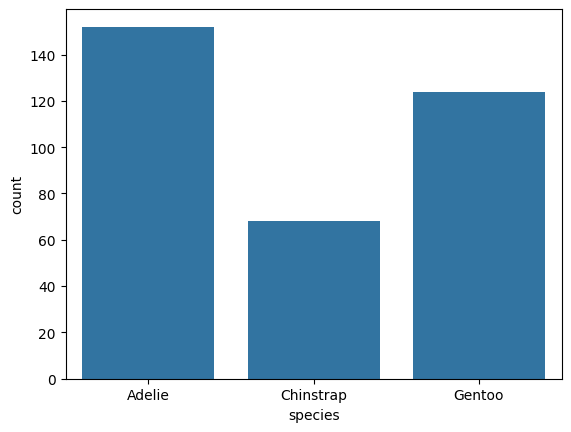

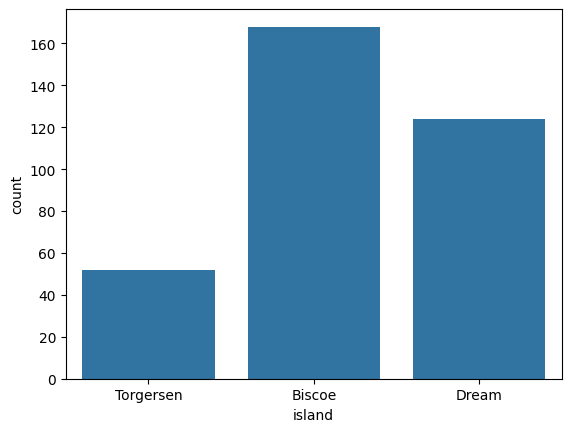

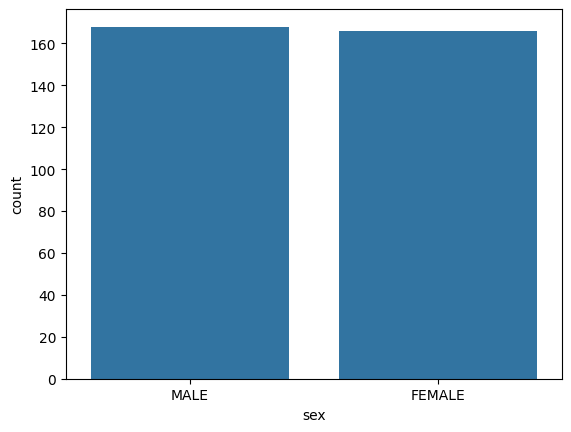

In [147]:
# object에 해당하는 그래프 그리기
for col in cols_cat.columns:
    sns.countplot(data=cols_cat, x=col)
    plt.show()

In [148]:
# group by 이용
df.groupby('island')['species'].value_counts()

island     species  
Biscoe     Gentoo       124
           Adelie        44
Dream      Chinstrap     68
           Adelie        56
Torgersen  Adelie        52
Name: count, dtype: int64

### 연속형 변수

In [149]:
cols_num = df.select_dtypes(include='number')
cols_num

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


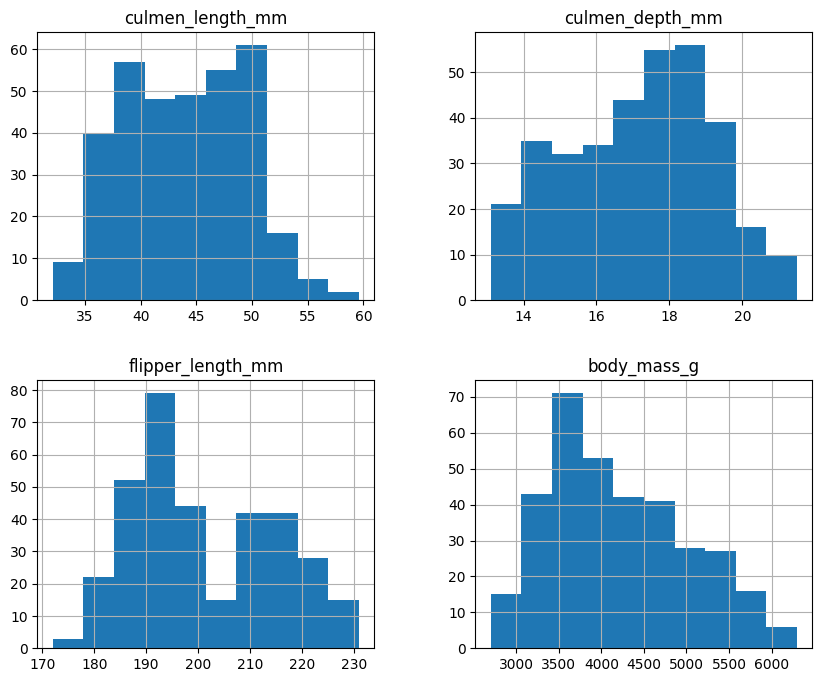

In [150]:
# 히스토그램 - 한쪽으로 쏠려있는지 이상치, 결측치 보기
cols_num.hist(figsize=(10, 8))
plt.show()

#### 이상치

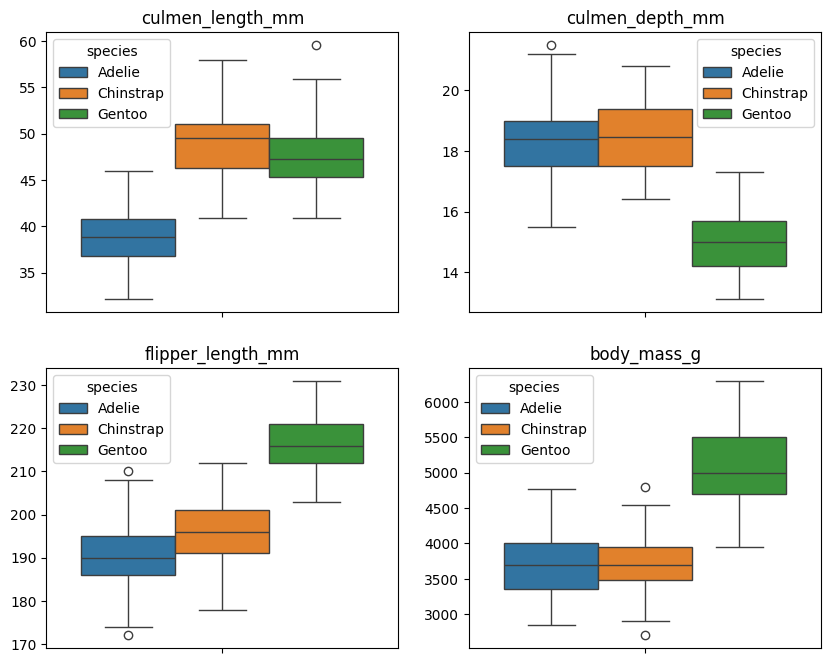

In [151]:
# 박스 플롯 - 이상치가 거의 없음(처리 X)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, col in enumerate(cols_num.columns): # i번째를 뽑기 위해서
    sns.boxplot(y=col, data=cols_num, ax=axes[i], hue=df['species'])
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)
    axes[i].set_title(col)
plt.show()

In [152]:
# 데이터 분리, 결측치 처리, 인코딩, 학습 진행

## 2. train, test 데이터 분리

In [153]:
# train_test_split 함수 사용
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['species'])
train.shape, test.shape

((275, 7), (69, 7))

### 결측치 처리

In [154]:
# 결측치 확인
cols_num.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

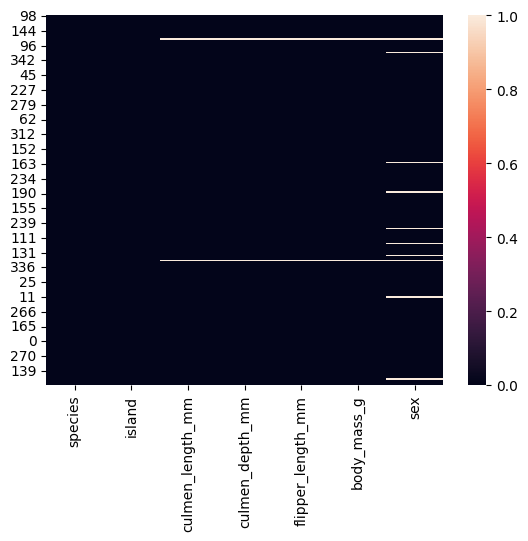

In [155]:
sns.heatmap(train.isna()) # 결측치가 존재 -> 날려버림
plt.show()

In [156]:
# 결측치는 날려버리기
train = train.dropna()
train.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

### X, y 분리

In [157]:
X_train = train.drop('species', axis=1)
y_train = train['species']
X_train.shape, y_train.shape

((265, 6), (265,))

In [158]:
X_train.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
98,Dream,33.1,16.1,178.0,2900.0,FEMALE
114,Biscoe,39.6,20.7,191.0,3900.0,FEMALE
118,Torgersen,35.7,17.0,189.0,3350.0,FEMALE
303,Biscoe,50.0,15.9,224.0,5350.0,MALE
343,Biscoe,49.9,16.1,213.0,5400.0,MALE


In [159]:
# OrdinalEncoder(인코딩 해서 그대로 다시 넣기) - 숫자로 인코딩(0,1,2...)
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
X_train[['island', 'sex']] = oe.fit_transform(X_train[['island', 'sex']])
X_train.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
98,1.0,33.1,16.1,178.0,2900.0,1.0
114,0.0,39.6,20.7,191.0,3900.0,1.0
118,2.0,35.7,17.0,189.0,3350.0,1.0
303,0.0,50.0,15.9,224.0,5350.0,2.0
343,0.0,49.9,16.1,213.0,5400.0,2.0


In [160]:
# y는 label encoding을 사용
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_e = le.fit_transform(y_train) # fit + transform
y_train_e

array([0, 0, 0, 2, 2, 2, 0, 2, 1, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0,
       0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2,
       0, 0, 1, 2, 0, 1, 0, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 0, 0, 1, 2, 0,
       0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0,
       1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 1, 0, 1,
       0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2,
       0, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 1,
       2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0,
       1])

### 스케일링

In [161]:
# robust scaler 사용
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
X_train_s = rs.fit_transform(X_train)
X_train_s

array([[ 0.        , -1.31868132, -0.375     , -0.82608696, -0.92      ,
        -1.        ],
       [-1.        , -0.6043956 ,  1.0625    , -0.26086957, -0.12      ,
        -1.        ],
       [ 1.        , -1.03296703, -0.09375   , -0.34782609, -0.56      ,
        -1.        ],
       ...,
       [ 1.        , -0.25274725,  0.375     , -0.08695652,  0.16      ,
         0.        ],
       [ 1.        , -0.92307692,  0.46875   , -0.43478261, -0.2       ,
        -1.        ],
       [ 0.        ,  0.62637363,  0.53125   ,  0.56521739,  0.04      ,
         0.        ]])

## 3. 모델 학습

In [162]:
# decision tree
# 랜덤 포레스트
# 2개 결과를 비교

### decision tree

In [163]:
# 데이터 확인, 변수명도 이에 맞게 작성
print(X_train_s.shape, y_train_e.shape)
print(type(X_train_s), type(y_train_e))

(265, 6) (265,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [164]:
# DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 42, max_depth = 3) # 규제
clf.fit(X_train_s, y_train_e)

DecisionTreeClassifier(max_depth=3, random_state=42)

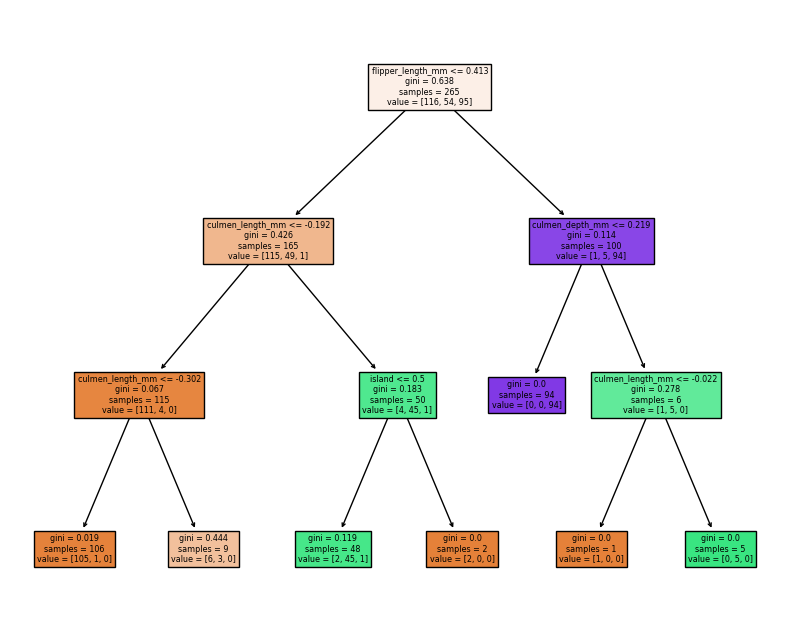

In [165]:
# 그림 그리기 - 깊이 6까지 파고들음
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 8))
plot_tree(clf, filled=True, feature_names=X_train.columns)
plt.show()

## 테스트

In [166]:
X_train.columns

Index(['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')

In [167]:
clf.feature_importances_ # 컬럼 중요도

array([0.02191913, 0.36080164, 0.06168261, 0.55559662, 0.        ,
       0.        ])

In [168]:
# test 데이터 전처리 - 결측치, oe, le, rs를 진행함
X_test = test.drop('species', axis = 1)
y_test = test['species']

In [169]:
X_test.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
151,Dream,41.5,18.5,201.0,4000.0,MALE
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
294,Biscoe,46.4,15.0,216.0,4700.0,FEMALE
337,Biscoe,48.8,16.2,222.0,6000.0,MALE
158,Dream,46.1,18.2,178.0,3250.0,FEMALE


In [170]:
# OrdinalEncoder 인코딩 진행
X_test[['island', 'sex']] = oe.transform(X_test[['island', 'sex']])
X_test.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
151,1.0,41.5,18.5,201.0,4000.0,2.0
1,2.0,39.5,17.4,186.0,3800.0,1.0
294,0.0,46.4,15.0,216.0,4700.0,1.0
337,0.0,48.8,16.2,222.0,6000.0,2.0
158,1.0,46.1,18.2,178.0,3250.0,1.0


In [171]:
# y는 label encoding
y_test_e = le.transform(y_test)
y_test_e

array([0, 0, 2, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 2,
       2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2,
       0, 0, 2])

In [172]:
# 스케일링
X_test_s = rs.transform(X_test)
X_test_s

array([[ 0.        , -0.3956044 ,  0.375     ,  0.17391304, -0.04      ,
         0.        ],
       [ 1.        , -0.61538462,  0.03125   , -0.47826087, -0.2       ,
        -1.        ],
       [-1.        ,  0.14285714, -0.71875   ,  0.82608696,  0.52      ,
        -1.        ],
       [-1.        ,  0.40659341, -0.34375   ,  1.08695652,  1.56      ,
         0.        ],
       [ 0.        ,  0.10989011,  0.28125   , -0.82608696, -0.64      ,
        -1.        ],
       [-1.        , -0.81318681, -0.40625   , -0.60869565, -0.78      ,
        -1.        ],
       [ 0.        ,  0.48351648,  0.53125   ,  0.13043478, -0.2       ,
         0.        ],
       [-1.        ,  0.62637363,  0.        ,  1.34782609,  1.24      ,
         0.        ],
       [ 0.        ,  0.14285714,  0.15625   , -0.26086957, -0.28      ,
        -1.        ],
       [ 0.        ,  0.37362637,  0.0625    , -0.26086957, -0.52      ,
         0.        ],
       [ 1.        , -1.15384615,  1.1875    ,  0.

In [173]:
X_test_s.shape, y_test_e.shape

((69, 6), (69,))

In [174]:
y_pred_tree = clf.predict(X_test_s)
y_pred_tree

array([0, 0, 2, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 2,
       2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1,
       0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2,
       0, 0, 2])

In [175]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
def print_metrics(y_true, y_pred, aver='macro'):
    print("accuracy:", accuracy_score(y_true, y_pred))
    print("recall_score:", recall_score(y_true, y_pred, average = aver))
    print("precision_score:", precision_score(y_true, y_pred, average = aver))
    print("f1_score:", f1_score(y_true, y_pred, average = aver))
    # 그림 그리기
    cfm = confusion_matrix(y_true, y_pred)
    s = sns.heatmap(cfm, annot=True, cmap='Blues', fmt = 'd', cbar=False)
    s.set(xlabel='Prediction', ylabel='Actual')
    plt.show()

accuracy: 0.9710144927536232
recall_score: 0.9650793650793651
precision_score: 0.9760683760683762
f1_score: 0.9700072621641249


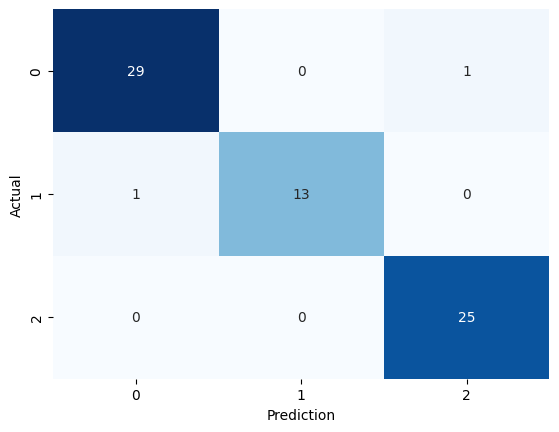

In [176]:
print_metrics(y_test_e, y_pred_tree)

## 랜덤 포레스트

In [177]:
from sklearn.ensemble import RandomForestClassifier

clf_r = RandomForestClassifier(n_estimators = 100, random_state=42)
clf_r.fit(X_train_s, y_train_e)

RandomForestClassifier(random_state=42)

In [181]:
y_pred_rf = clf_r.predict(X_test_s)
y_pred_rf

array([0, 0, 2, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 2,
       2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 2, 1, 2,
       0, 0, 2])

accuracy: 0.9855072463768116
recall_score: 0.9888888888888889
precision_score: 0.9777777777777779
f1_score: 0.9828560296123126


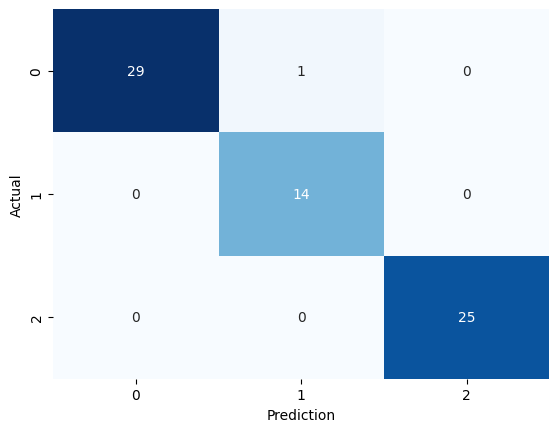

In [182]:
print_metrics(y_test_e, y_pred_rf)

# SVM 이용